In [1]:
import torch
import triton
import triton.language as tl
import my_cuda_ops

In [20]:
# add by cuda
def reduce_cuda(x: torch.Tensor):
    # We need to preallocate the output.
    assert x.is_cuda
    N = x.shape[0]
    output = torch.empty(1, dtype=x.dtype, layout=x.layout, device=x.device)
    # 创建输出张量
    my_cuda_ops.sum(x, output, N, 1)
    return output

In [ ]:
@triton.jit
def reduce_sum_kernel(
        input_ptr,  # 第一个向量的指针
        output_ptr,  # 输出向量的指针
        n_elements,  # 向量的大小
        BLOCK_SIZE: tl.constexpr,  # 每个 block 的大小
):
    # 只有一个block
    offsets = tl.arange(0, BLOCK_SIZE)

    # 创建一个掩码以防止越界访问
    mask = offsets < n_elements

    # 从全局内存加载数据
    x = tl.load(input_ptr + offsets, mask=mask, other=0.0)
    output = tl.sum(x, axis=0)
    # 将结果存储回全局内存
    if tl.program_id(0) == 0:
        tl.store(output_ptr, output)
    # tl.store(output_ptr + offsets, output, mask=mask)

def reduce_sum(x: torch.Tensor):
    assert x.is_cuda
    n_elements = x.numel()
    BLOCK_SIZE = triton.next_power_of_2(n_elements) # 上限貌似是65536，再高会降速， 比1048576高会报错，内存溢出

    # 输出只有一个元素
    output = torch.empty(1, device='cuda', dtype=torch.float32)

    reduce_sum_kernel[(1,)](x, output, n_elements, BLOCK_SIZE=BLOCK_SIZE)

    return output

# 如果向量长度太长，需要进行分块循环
# @triton.autotune(
#     configs=[
#         triton.Config({'BLOCK_SIZE': 1024},  num_warps=4,  num_stages=2),
#         triton.Config({'BLOCK_SIZE': 2048},  num_warps=8,  num_stages=3),
#         triton.Config({'BLOCK_SIZE': 4096}, num_warps=16, num_stages=4),
#     ],
#     key=['n_elements']
# )
# @triton.jit
# def reduce_sum_kernel(
#         input_ptr,  # 第一个向量的指针
#         output_ptr,  # 输出向量的指针
#         n_elements,  # 向量的大小
#         BLOCK_SIZE: tl.constexpr,  # 每个 block 的大小
# ):
#     # 一行的元素数量 N 一般远超 BLOCK_SIZE，故需要对 N 进行分块计算
#     sum = 0
#     _sum= tl.zeros([BLOCK_SIZE], dtype=tl.float32)
#     for off in tl.range(0, n_elements, BLOCK_SIZE):
#         # 创建一个掩码以防止越界访问
#         offsets = off + tl.arange(0, BLOCK_SIZE)
#         mask = offsets < n_elements

#         # 从全局内存加载数据
#         x = tl.load(input_ptr + offsets, mask=mask, other=0.0)
#         _sum += x
#         # 将结果存储回全局内存
#     sum = tl.sum(_sum, axis=0)
#     if tl.program_id(0) == 0:
#         tl.store(output_ptr, sum)
#     # tl.store(output_ptr + offsets, output, mask=mask)

# def reduce_sum(x: torch.Tensor):
#     assert x.is_cuda
#     n_elements = x.numel()
#     # BLOCK_SIZE = triton.next_power_of_2(n_elements)

#     # 输出只有一个元素
#     output = torch.empty(1, device='cuda', dtype=torch.float32)

#     # 启动 grid
#     # grid = lambda meta: (1,)  # 这里只用一个线程块
#     reduce_sum_kernel[(1,)](x, output, n_elements)

#     return output.item()

In [76]:
# We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:
torch.manual_seed(0)
x = torch.rand(4096, device='cuda')
print(x.shape)
output_torch = torch.sum(x, dim=0)
output_cuda = reduce_cuda(x)
output_triton = reduce_sum(x)
print(output_torch)
print(output_cuda)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The maximum difference between torch and cuda is '
      f'{torch.max(torch.abs(output_torch - output_cuda))}')

torch.Size([4096])
tensor(2055.7622, device='cuda:0')
tensor([2055.7622], device='cuda:0')
The maximum difference between torch and triton is 0.0
The maximum difference between torch and cuda is 0.0


In [78]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 21, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'cuda'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'CUDA'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.sum(x, dim=0), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: reduce_sum(x), quantiles=quantiles)
    if provider == 'cuda':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: reduce_cuda(x), quantiles=quantiles)
    gbps = lambda ms : 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

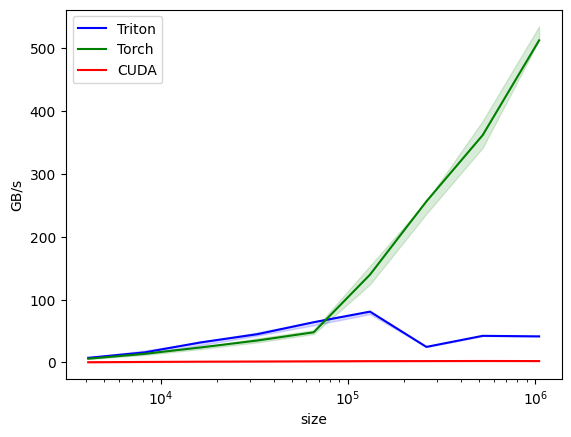

vector-add-performance:
        size     Triton       Torch      CUDA
0     4096.0   7.384615    6.000000  0.413793
1     8192.0  15.999999   13.714286  0.868778
2    16384.0  31.999999   24.000000  1.276543
3    32768.0  44.928704   34.909091  1.538500
4    65536.0  63.999998   48.000000  1.846154
5   131072.0  80.842109  139.636363  2.152768
6   262144.0  24.774194  255.999991  2.240700
7   524288.0  42.372414  361.411758  2.382319
8  1048576.0  41.513512  511.999982  2.271349


In [81]:
benchmark.run(print_data=True, show_plots=True)